This is a script which contains different propagation algorithms and their error analyse.

2024-09-30
Wenyi Li
references: 

[1] SAS. Optica 2024 

[2] Bandlimited Angular Spectrum Method. OE 2009

[3] Fast-Fourier-transform (FFT) based direct integration (FFT-DI). AO 2006

The script will be introduced as following chapters
1. Theory of wave equation and different methods
2. Algorithm of each method
3. Comparison and analyze

#### 1. Theory

##### 1.1 Helmholtz equation
For linear homogenous isotropic media, the 3D scalar Helmholtz equation can be written as following  
$$
\nabla^2 \psi + k^2 \psi = 0 \tag{1}
$$ 
The Rayleigh-Sommerfeld solution for an input monochramatic source field is:
$$
U(x,y,z) = \iint{U_0(x',y',0)}\frac{exp(i2\pi r' \lambda^{-1})}{r'}\frac{z}{r'}(\frac{1}{2\pi r'}+\frac{1}{i\lambda})dx'dy' \tag{2}
$$

##### 1.2 numerical method

##### 1.2.1 Directly integration method (FFT-DI) (This is the RS we called in out group, which is confusing, because all the numerical methods in the following based on the RS integration)

$$
h(x,y,z) = \frac{exp(i2\pi r \lambda^{-1})}{r}\frac{z}{r}(\frac{1}{2\pi r}+\frac{1}{i\lambda}) \tag{3}
$$
where $r = \sqrt{x^2+y^2+z^2}$, and the method is formulated by the following:
$$
U(x,y,z) = U_0(x,y,0) * h(x,y,z) \tag{4}
$$
The convolution is calculated by 3 times FFT.
##### 1.2.2 Angular Spectrum Method (AS)

$$
H(u,v;z) = \mathcal{F}\{h(x,y,z)\}=exp(i2\pi w z)
$$
$$
w = w(u,v) = \sqrt{\lambda^{-2}-u^2-v^2} 
$$
PS: If the inner part is not less than 0, then $w$ is zero. So the field will be calculated by:
$$
U(x,y,z) = \mathcal{F}^{-1}\{\mathcal{F}\{U_0(x,y,z) * H(u,v;z)\} \}
$$
Therefore, there is only 2 times FFT involved. 50% faster than 3 times FFT.

##### 1.2.2.1 Band-limited AS
Because the AS has numerical errors when you directly implement it due to sampling problem of the Transfer Function H. [2] 
By limiting the bandwidth of the propagation field and expands the region in which exact field can be calcualted by the AS.
1. Because FFT is circular convolution, there might be errors if the result we are interested is out of the computational window. To solve this, we need to double the input field.
2. if the input size is $S_x$, and the padded size is $2S_x$, the accuracy drops when $z>10S_x$. This is because the transfer function is undersampled.
$$
\Delta u = 1/(2S_x) = 1/(2N_x \Delta x)
$$
We can calculate the gradient of the Transfer function 
$$
f_u = \frac{\partial H}{\partial u} = \frac{uz}{[\lambda^{-2}-u^2]^{1/2}}
$$
therefore, AS is only accurate when $1/\Delta u \geq 2|f_u|$, which avoids aliasing error. We can calculate the limit of u as following:
$$
|u| \leq \frac{1}{[(2\Delta u z)^2+1]^{1/2}\lambda} \equiv u_{limit}
$$
As a result, the TF should be clipped within a bandwidth of $2u_{limit}$ 
$$
H'(u,z) = H(u,z)rect(u\frac{u}{2u_{limit}})
$$
Those are 1D derivation, but 2D can be similarily derived, u and v have same expression as 1D. The H will be 
$$
H'(u,v;z) = H(u,v;z)rect(\frac{u}{2u_{limit}})rect(\frac{v}{2v_{limit}})
$$

##### 1.2.2.2 minumum bandwidth required for exact numerical propagation. 
Refer to [2], the bandwidth of the proposed method always satisfies the condition of the minimum bandwidth.


In [44]:
import numpy as np
import matplotlib.pyplot as plt

#### 2. Algorithm

2.1 input field 

In [275]:
L_box = 128e-6 
D_box = L_box / 10
N_box = 512 
lbd = 500e-9

y_box = np.linspace(-L_box/2, L_box/2, N_box, endpoint=False)
x_box = y_box.reshape(N_box, 1)

U_box = ((x_box)**2 <= (D_box / 2)**2) * (y_box**2 <= (D_box / 2)**2) *\
        (np.exp(1j * 2 * np.pi / lbd * y_box * np.sin(5/ 360 * 2 * np.pi)))

z_box = 5 / N_box / lbd * L_box**2 * 2  

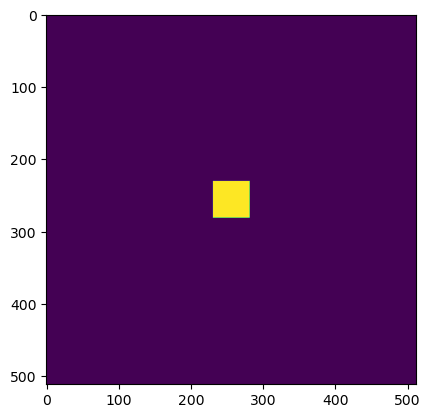

In [276]:
plt.imshow(np.abs(U_box))

2.1 FFT-DI
$$
h(x,y,z) = \frac{exp(i2\pi r \lambda^{-1})}{r}\frac{z}{r}(\frac{1}{2\pi r}+\frac{1}{i\lambda}) \tag{3}
$$
where $r = \sqrt{x^2+y^2+z^2}$, and the method is formulated by the following:

In [260]:
def FFT_DI(U0,dx,z,lambda_):
    
    N, M = np.shape(U0)
    x = np.fft.fftshift(np.fft.fftfreq(N,1/(N*dx)))
    y = np.fft.fftshift(np.fft.fftfreq(N,1/(N*dx)))
    X, Y = np.meshgrid(x,y)
    r = np.sqrt(X**2+Y**2+z**2)
    h = np.exp(2*np.pi*r/lambda_*1j)/r * z/r * (1/(2*np.pi*r)+1/(lambda_*1j))
    Uz = np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(np.fft.ifftshift(U0)) * np.fft.fft2(np.fft.ifftshift(h))))

    return x,r,h,Uz

In [261]:
# Test FFT_DI
x,r,h,Uz = FFT_DI(U_box, L_box/N_box, z_box, lbd)

In [262]:
x1 = np.linspace(0,1,3)
print(x1)
np.fft.ifftshift(np.fft.fftshift(x1))

[0.  0.5 1. ]


array([0. , 0.5, 1. ])

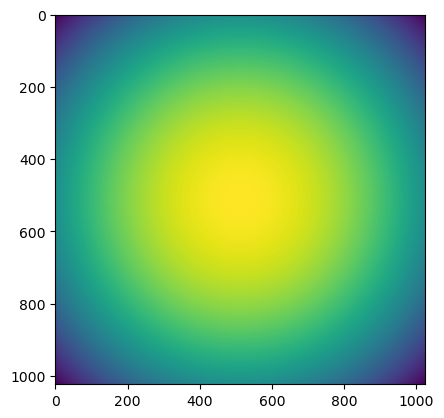

In [263]:
plt.imshow(np.abs(h))

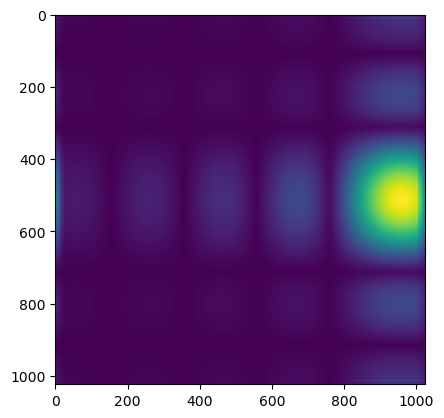

In [264]:
plt.imshow(np.abs(Uz))

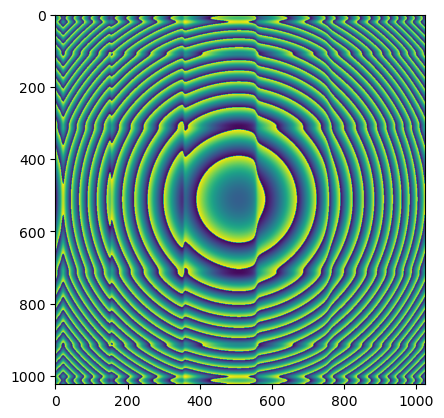

In [265]:
plt.imshow(np.angle(Uz))

In [266]:
np.fft.fftshift(np.fft.fftfreq(10))

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4])

2.2 AS

In [267]:
def AS(U0,dx,z, lambda_):
    
    N, M = np.shape(U0)
    u = np.fft.fftfreq(N,dx)
    v = np.fft.fftfreq(N,dx)
    U, V = np.meshgrid(u,v)
    H_kernel = lambda_**(-2)-U**2-V**2
    H_kernel = np.where(H_kernel < 0, 0, H_kernel)
    H = np.exp(np.sqrt(H_kernel)*2*np.pi*z*1j)
    Uz = np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(np.fft.fftshift(U0)) * H))

    return u, H_kernel, H, Uz

In [268]:
# test for AS
u, H_kernel, H, Uz = AS(U_box, L_box/N_box, z_box, lbd)


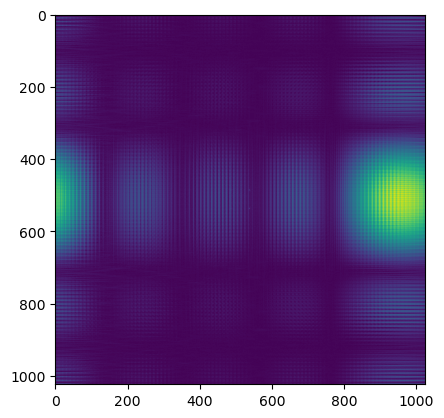

In [269]:
plt.imshow(np.abs(Uz))

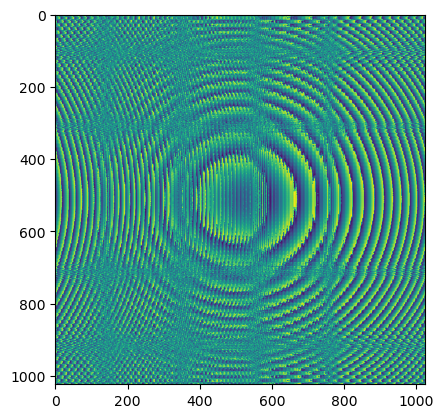

In [270]:
plt.imshow(np.angle(Uz))

2.3 Band-limited AS
$$
|u| \leq \frac{1}{[(2\Delta u z)^2+1]^{1/2}\lambda} \equiv u_{limit}
$$
$$
H'(u,v;z) = H(u,v;z)rect(\frac{u}{2u_{limit}})rect(\frac{v}{2v_{limit}})
$$

In [271]:
def B_AS(U0,dx,z, lambda_):
    
    N,M = np.shape(U0)
    u = np.fft.fftfreq(N,dx)
    v = np.fft.fftfreq(N,dx)
    U, V = np.meshgrid(u,v)
    H_kernel = lambda_**(-2)-U**2-V**2
    H_kernel = np.where(H_kernel < 0, 0, H_kernel)
    H = np.exp(np.sqrt(H_kernel)*2*np.pi*z*1j)

    du = 1/N/dx
    u_limit = 1/(lambda_*np.sqrt((2*du*z)**2+1))
    H_prime = np.where((np.abs(U) <= u_limit) & (np.abs(V) <= u_limit), H, 0)  
    Uz = np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(np.fft.ifftshift(U0)) * H_prime))

    return u, H, H_prime, Uz

In [272]:
# test for AS
u, H_kernel, H, Uz = B_AS(U_box, L_box/N_box, z_box, lbd)

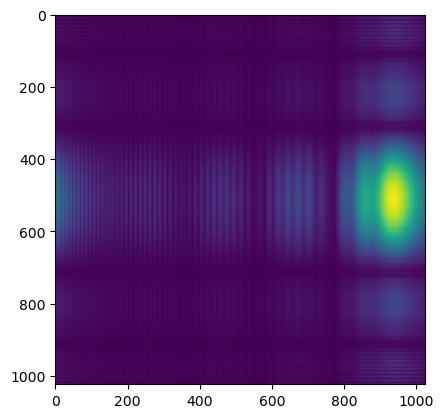

In [273]:
plt.imshow(np.abs(Uz))

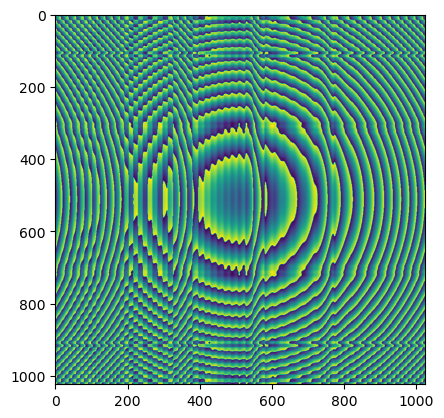

In [274]:
plt.imshow(np.angle(Uz))

In [277]:
def zero_pad(arr):
    '''
    Pad arr with zeros to double the size. First dim is assumed to be batch dim which
    won't be changed
    '''
    out_arr = np.zeros(arr.shape[0], arr.shape[1] * 2, arr.shape[2] * 2, dtype=arr.dtype)
    
    as1 = (arr.shape[1] + 1) // 2
    as2 = (arr.shape[2] + 1) // 2
    out_arr[:, as1:as1 + arr.shape[1], as2:as2 + arr.shape[2]] = arr
    return out_arr

def zero_unpad(arr, original_shape):
    '''
    Strip off padding of arr with zeros to halve the size. First dim is assumed to be batch dim which
    won't be changed
    '''
    as1 = (original_shape[1] + 1) // 2
    as2 = (original_shape[2] + 1) // 2
    return arr[:, as1:as1 + original_shape[1], as2:as2 + original_shape[2]]

##### 3. Comparison

In [279]:
from scipy.special import fresnel
import jax.numpy as jnp

In [280]:
# 3.1 analytical solution of directly integrated of the field
# refer from Chromatix package

D = 40
w = D / 10
z = 100
spectrum = 0.532
n = 1.33


def analytical_result_square_aperture(x, z, w, spectrum, n):
    Nf = (w / 2) ** 2 / (spectrum / n * z)

    def intensity(x):
        Smin, Cmin = fresnel(jnp.sqrt(2 * Nf) * (1 - 2 * x / w))
        Splus, Cplus = fresnel(jnp.sqrt(2 * Nf) * (1 + 2 * x / w))

        return 1 / jnp.sqrt(2) * (Cmin + Cplus) + 1j / jnp.sqrt(2) * (Smin + Splus)

    U = (
        jnp.exp(1j * 2 * jnp.pi * z * n / spectrum)
        / 1j
        * intensity(x[0])
        * intensity(x[1])
    )
    # Return U/l as the input field has area l^2
    return U / w